<h1><center>Udacity Self Driving Car - Project 1 (Finding Lane Lines)</center></h1>

# Background

Recently I decided to join the Udacity's Self Driving Car Nanodegree. With all the apprehensions about cost and whether it will be worth it or not I finally decided to take
the jump into this field. I had a few other things going on and I wasn't sure whether I could even devote the time to do it. However, after much speculation however I convinced
myself that this was the way to go and enrolled in the class. So this blog post is serving as a writeup for the first project.

As soon as you start the course, this project becomes due in a week. So you have to jump right in and get the project working asap in order to submit it.


# Finding Lane Lines on the Road

The first project from this course was lane line detection from images and videos. Udacity provided test images and videos for testing the overall pipeline out.
The requirements were to use OpenCV with Python and IPython Notebooks to demonstrate the solution. This turned out to be quite an interesting project overall for
me. It had the right amount of technicality along with some intuition needed to solve the problem.


# Terminology:

* ROI (Region of Interest): Defines the region in an image where we are likely to find the lane lines.
* Canny: Canny Edge Detection
* Hough: Probabilistic Hough Transform

# Assumptions:

* The region of interest is always assumed to be at the center which essentially
means that it's always assumed that the car starts between the 2 lanes.
* Filtering currently is a very naive, in which all lines whose slope falls between -0.5 to 0.5 are ignored.

# Results:

Currently, the same pipeline works for both white and yellow lines as well as the optional challenge with just changing parameters for ROI and hough. 

In [49]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [50]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("white.mp4"))

In [51]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("yellow.mp4"))

In [52]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("extra.mp4"))

# Algorithm

**Finding Lane Lines on the Road**

The goals / steps of this project are the following:
* Make a pipeline that identifies the lane lines on the road.
* Once the lane lines are identified, make it a single straight line which is uniform across frames.
* Identify outliers and make sure that they don't break the overall algorithm

# Pipeline

The problem consisted of a combination of images as well as videos. The idea was first to first describe a pipeline which works on both images and videos. The images provided
were pretty straightforward and didn't present too much of a problem. However, the videos turned out to be trickier than I thought to deal with. Below I describe the pipeline
which I used to describe the problem.


## Grayscale

The first step in the pipeline is to convert all the images to grayscale. This is done since we want to extract just white / yellow lane lines from the image which tend to stand out in grayscale images.

## Gaussian Blur & Canny:

The first step of the algorithm is to blur the image. The most common form of this is the Gaussian Blur. Blurring the image reduces the noise in the image which makes it easier for Canny edge detection to find the edges 


In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

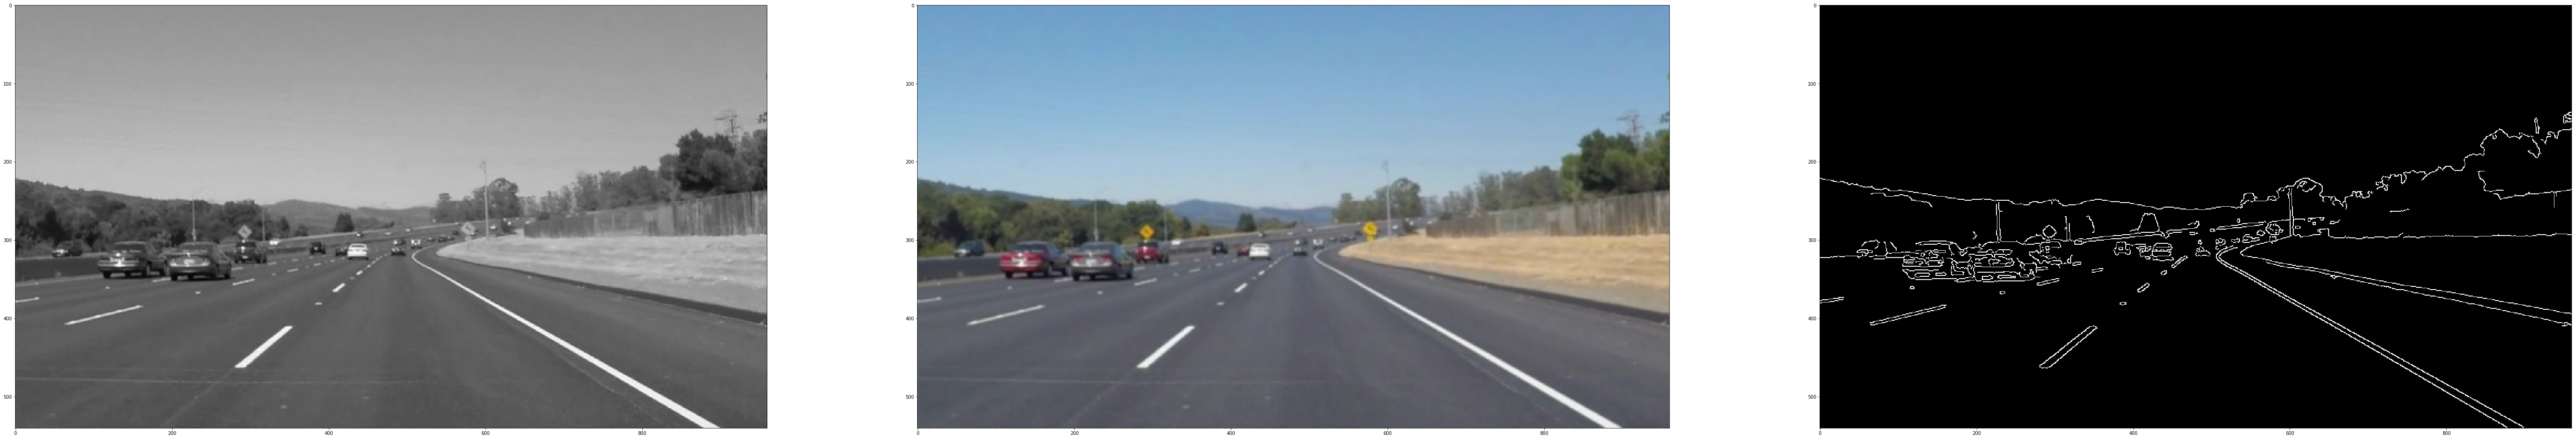

In [38]:
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
fig = plt.figure(figsize=(100, 100))
plt.subplot(1, 3, 1)
plt.imshow(gray, cmap='gray')
blur = cv2.GaussianBlur(image, (5, 5), 0)
plt.subplot(1, 3, 2)
plt.imshow(blur, cmap='gray')
canny = cv2.Canny(blur, 50, 150)
plt.subplot(1, 3, 3)
plt.imshow(canny, cmap='gray')

The above set of images show the Canny edge detection algorithm working with a blurred image. As can be seen a lot of extraneous lines have been reduced as compared to the image below which does canny edge detection on the original image itself.

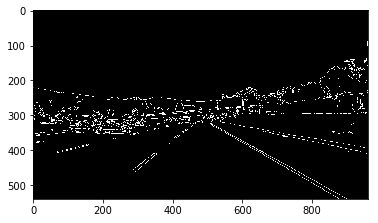

In [39]:
canny = cv2.Canny(image, 50, 150)
plt.imshow(canny, cmap='gray')

## Region of Interest

As can be seen from the image above the canny edge selection selection generates a lot of edges in the image. However, we are just interested in extracting the lane lines which means we have to select a particular area in the image where to look for. 

Now region of interest will vary based on where the camera is mounted in the car and has a significant effect on the pipeline following it.

For this case, I chose to keep it like a parallelogram kind of image. This gave me a decent area to work with and the image below shows the output.

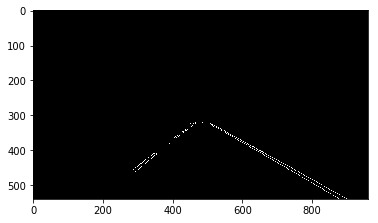

In [40]:
# This time we are defining a four sided polygon to mask
mask = np.zeros_like(canny)
ignore_mask_color = 255

imshape = canny.shape
y = imshape[0]
x = imshape[1]
y_offset = 50
x_offset = 20

roi_vertices = np.array([[(15, y),
                          (x / 2 - x_offset, y / 2 + y_offset),
                          (x / 2 + x_offset, y / 2 + y_offset),
                          (x - 15, y)]],
                          dtype=np.int32)

cv2.fillPoly(mask, roi_vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(canny, mask)

masked_edges_img = np.dstack((masked_edges, masked_edges, masked_edges))
plt.imshow(masked_edges_img)

## Hough Transform

The Hough transform is a technique which can be used to isolate features of a particular shape within an image. So once we have the edges from Canny edge detected. It returns a bunch of lines which correspond to both the left lane and the right lane but without any classification whatsoever. This means that we have to decide and infer which lines classify to be the left lane and which ones fall to the right.

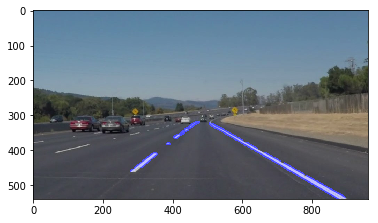

In [41]:
rho = 1
theta = 31 * np.pi/180
threshold = 10
min_line_length = 5
max_line_gap = 10

lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
line_image = np.copy(image) * 0

for line in lines:
    for x0, y0, x1, y1 in line:
        cv2.line(line_image, (x0, y0), (x1, y1), (0, 0, 255), 8)
        
line_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0)
plt.imshow(line_edges, cmap='gray')

## Extrapolation & Smoothing

This was one part of the pipeline where I spent most of my time on. The problem here was to find 2 lines, one for the left lane and one for the right lane. So from the image above it looks pretty straightforward to do this but in the presence of outliers it could really be a tough process. For this problem I looked at 2 approaches and one of them seemed to work for me better than the other. However, before we get into that process, it is important to classify which lines can be used to draw the left lane vs which lines can be used for the right line.

The way I solved it was to take a center line across the Region of Interest block and then classify the lines accordingly.

#### Filtering Lines

Once the lines have been classified to left lane and right lane, I apply a naive filtering algorithm to remove the lines which won't contribute to the problem. As can be seen in the image below because of the extreme white regions in the road, hough lines detects these lines and hence have to be removed. The process for removing those was naive since I basically eliminated all lines whose slope lies between -0.5 to 0.5. This kind of eliminates all the horizontal or sort of horizontal lines. This approach is done for both the Dominant line approach as well as the Least Squares fitting algorithm I used.

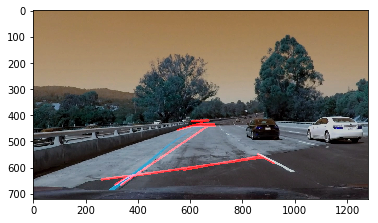

In [44]:
line_filtering = mpimg.imread("writeup_imgs/line_filtering.jpg")
plt.imshow(line_filtering)

#### Dominant Line Approach

In the dominant line approach, I compute the line with the longest length and use that as my line for the road. This approach needed averaging over several frames but I didn't get the time to do it and the results from this weren't as good so I abandoned it.

#### Least Squares Fitting

The least squares fitting approach is an approach where line fitting is performed on a bunch of points. Its a linear fit approach. This approach works really well when there are no outliers. However, in the presence of outliers then the approach starts showing problems where it tries to fit lines to the outlier points too. The code below shows the idea with least squares fitting.

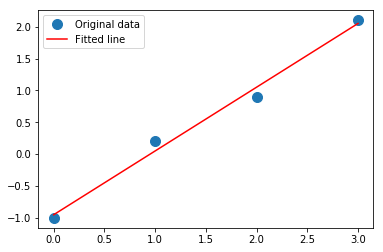

In [47]:
x = np.array([0, 1, 2, 3])
y = np.array([-1, 0.2, 0.9, 2.1])

A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y)[0]

plt.plot(x, y, 'o', label='Original data', markersize=10)
plt.plot(x, m*x + c, 'r', label='Fitted line')

plt.legend()
plt.show()

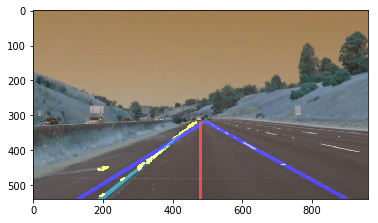

In [53]:
least_square_naive = mpimg.imread('writeup_imgs/tilt.jpg')
plt.imshow(least_square_naive)

* Yellow: Hough transform output
* Dark Blue: Least Squares Fitting output
* Red: Center for Region of Interest

As can be seen the yellow on the left of the left lane is an outlier and that causes the least square fitting to tilt slightly.

#### Averaging over Frames

So to solve the above problem I used least squares fitting on current frame coupled with N previous frames in the case of a video. This helped smooth out the least square fitted lines.

# Approach & Debugging

The problem here needed a lot of debugging especially when working with videos and I tried various approaches to deal with it. For example, I wrote an Ipython Notebook which would let me play around with thresholds for canny as well as different values for Hough Transform.

https://github.com/ssarangi/CarND-LaneLines-P1/Experiment.ipynb

This was interesting and helped me quite a bit although I found Matplotlib to be way too slow when subplots are used. 

Also I created standalone scripts to work with PyCharm and made a bunch of helper functions to run various kind of scenarios.

# Potential Shortcomings

Currently the system is not very robust and very prone to breaking. Here I have listed out the issues I see with this system.

* Region of Interest is fixed - This however doesn't work well when you have a restricted region and then the road changes curvature.

* Outliers on the road - I found that in the videos of SolidYellowLeft.mp4 and SolidWhiteRight.mp4 there were multiple spots where outliers were either on the road or on to the side of the road. These were typically white in color causing hough to detect them. Using such lines causes least squares to go berserk.

* Least Squares for Fitting: Although Least squares is a good approximation it is very sensitive to outliers and hence not a good approximation in some cases which can be seen in the videos where the line tends to tilt away from the lanes

# Improvements to Pipeline

There are various things that needs to be improved in the pipeline to make it more robust.

* Current assumption is that the region of interest if fixed. It would be helpful to see how changing the region of interest actually affects the other parts of the pipeline.

* As I am filtering for outliers, there could be cases where we end up with no points. In that case I just use the data from previous frames to extrapolate, however, this won't work with single images. This could possibly be improved by figuring out a better outlier detection approach than just filtering across a range of slopes.

* Also the challenge.mp4 has areas of shadow etc where we tend to use the same canny and hough parameters which could be changed depending on if we detect areas of brightness or darkness depending on average values from previous frames.

* The pipeline hasn't been tested in rainy, snowy weather or at night so there are possible improvements to do on that front.

# Conclusion

Overall, I enjoyed this project thoroughly and learnt quite a bit of things but there are definitely certain areas which need to be looked at more and more closely to come up with an acceptable solution which would work across a wide range of weather & lighting conditions.